# Project 1 - High Frequency Price Prediction
Author: Liting Xiao

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 12})

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, LogisticRegression

In [2]:
def train_val_plot(xaxis, train, val, title, savefig=False, figname=None):
    plt.plot(xaxis, train, label='Training')
    plt.plot(xaxis, val, label='Validation')
    plt.xlabel('Regularization strength')
    plt.ylabel(title)
    plt.legend()
    if savefig:
        plt.savefig(figname)
    plt.show()

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Data Processing

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
def preprocess(data):
    # fill NaN
    data['opened_position_qty '].fillna(np.floor(data['transacted_qty']/2), inplace = True)
    data['closed_position_qty'].fillna(np.ceil(data['transacted_qty']/2), inplace = True)
    
    # add some features
    data['diff'] = data['ask1'] - data['bid1']
    data['diff_vol'] = data['bid1vol'] - data['ask1vol']
    data['pot_vol'] = data['bid1vol'] + data['ask1vol']
    
    data['frac_price'] = data['last_price'] / data['mid']

    data['ask_spread'] = data['ask1'] / data['ask5']
    #data['ask_vol_spread'] = data[{'ask1vol','ask2vol','ask3vol','ask4vol','ask5vol'}].min().div(data[{'ask1vol','ask2vol','ask3vol','ask4vol','ask5vol'}].max())
    data['bid_spread'] = data['bid1'] / data['bid5']
    #data['bid_vol_spread'] = data[{'bid1vol','bid2vol','bid3vol','bid4vol','bid5vol'}].min().div(data[{'bid1vol','bid2vol','bid3vol','bid4vol','bid5vol'}].max())
    return data

In [6]:
train = preprocess(train)
test = preprocess(test)

In [7]:
test.head()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,ask2vol,ask3vol,ask4vol,ask5vol,diff,diff_vol,pot_vol,frac_price,ask_spread,bid_spread
0,592380,5178.4,5178.3,1.0,11.0,12.0,-10,5178.2,5178.0,5177.8,...,4,1,5,2,0.2,2,4,1.000019,0.999730,1.000155
1,592381,5133.0,5132.9,1.0,0.0,1.0,1,5132.8,5132.6,5132.4,...,8,1,1,1,0.2,-3,5,1.000019,0.999766,1.000156
2,592382,5177.4,5178.0,2.0,0.0,2.0,2,5177.2,5176.8,5176.6,...,4,1,2,5,1.6,1,15,0.999884,0.999846,1.000232
3,592383,5093.6,5093.9,0.0,2.0,2.0,-1,5093.2,5093.0,5092.8,...,1,11,6,2,1.4,7,9,0.999941,0.999843,1.000236
4,592384,5189.2,5189.2,0.0,0.0,0.0,0,5188.8,5188.6,5188.4,...,2,1,3,4,0.8,-2,4,1.000000,0.999692,1.000154


In [8]:
# train/val split
train_x, val_x, train_y, val_y = train_test_split(
    train.drop(['id', 'y'], axis=1).values, train['y'].values, test_size=0.2, random_state=42)

# use all training data for final training
final_train_x, final_train_y = train.drop(['id', 'y'], axis=1).values, train['y'].values
test_x = test.drop(['id'], axis=1).values

In [9]:
# feature scaling
scaling = MinMaxScaler().fit(train_x)
train_x = scaling.transform(train_x)
#scaling = MinMaxScaler().fit(val_x)
val_x = scaling.transform(val_x)

In [10]:
#scaling = MinMaxScaler().fit(test_x)
test_x = scaling.transform(test_x)

#scaling = MinMaxScaler().fit(final_train_x)
final_train_x = scaling.transform(final_train_x)

## Ridge Regression

In [11]:
alpha = np.geomspace(1, 1e4, 30)
train_roc, val_roc = [], []
train_mse, val_mse = [], []
train_r2, val_r2 = [], []
for a in alpha:
    ridge = Ridge(alpha = a)
    ridge.fit(train_x, train_y)
    
    val_roc.append(roc_auc_score(val_y, ridge.predict(val_x)))
    train_roc.append(roc_auc_score(train_y, ridge.predict(train_x)))
    
    val_mse.append(mean_squared_error(val_y, ridge.predict(val_x)))
    train_mse.append(mean_squared_error(train_y, ridge.predict(train_x)))
    
    val_r2.append(r2_score(val_y, ridge.predict(val_x)))
    train_r2.append(r2_score(train_y, ridge.predict(train_x)))

1.0


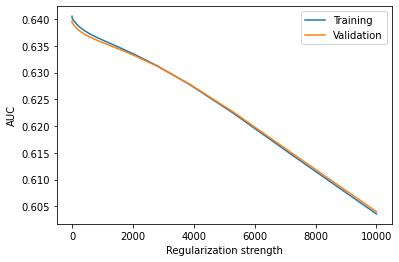

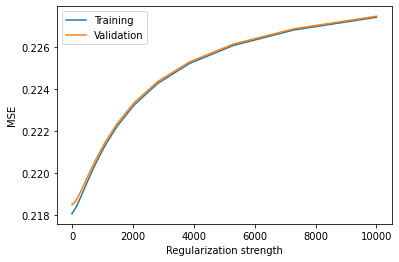

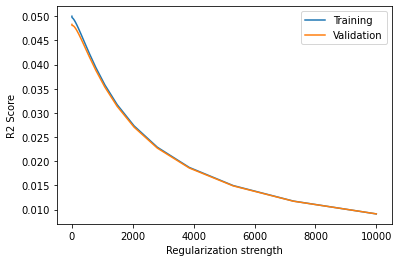

In [12]:
print(alpha[np.argmax(val_roc)])
train_val_plot(alpha, train_roc, val_roc, 'AUC', savefig=True, figname='ridge_auc.png')
train_val_plot(alpha, train_mse, val_mse, 'MSE', savefig=False, figname=None)
train_val_plot(alpha, train_r2, val_r2, 'R2 Score', savefig=False, figname=None)

In [13]:
train.drop(['id', 'y'], axis=1).columns[np.argsort(ridge.coef_)]

Index(['ask1vol', 'ask_spread', 'bid_spread', 'pot_vol', 'ask2vol', 'ask5vol',
       'ask3vol', 'd_open_interest', 'ask4vol', 'bid1', 'mid', 'ask1', 'bid2',
       'bid5', 'bid3', 'bid4', 'ask2', 'ask3', 'ask4', 'ask5', 'last_price',
       'bid5vol', 'bid3vol', 'bid4vol', 'closed_position_qty',
       'opened_position_qty ', 'transacted_qty', 'bid2vol', 'diff', 'bid1vol',
       'diff_vol', 'frac_price'],
      dtype='object')

In [14]:
def pred_to_csv(pred_y, test_x, name):
    result = test_x['id']
    result = result.to_frame()
    result = pd.concat([result, pd.DataFrame(pred_y)], axis=1)
    result.to_csv(name, index=False)

In [15]:
ridge = Ridge(alpha = 1.0).fit(final_train_x, final_train_y)
pred_y = ridge.predict(test_x)

In [16]:
roc_auc_score(train_y, sigmoid(ridge.predict(train_x)))

0.6405446828602503

In [17]:
sigmoid(pred_y).min()

0.2811738688185847

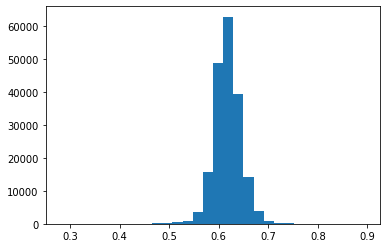

In [18]:
plt.hist(sigmoid(pred_y), bins=30); plt.show()

In [19]:
pred_to_csv(sigmoid(pred_y), test, 'results/ridge_submission.csv')

## Logistic Regreession

1.0


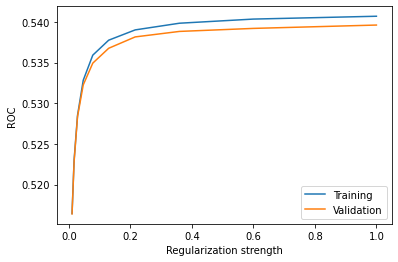

In [20]:
alpha = np.geomspace(1e-2, 1., 10)
train_roc, val_roc = [], []
for a in alpha:
    clf = LogisticRegression(C=a, solver='sag', n_jobs=-1)
    clf.fit(train_x, train_y)
    
    val_roc.append(roc_auc_score(val_y, clf.predict(val_x)))
    train_roc.append(roc_auc_score(train_y, clf.predict(train_x)))
print(alpha[np.argmax(val_roc)])
train_val_plot(alpha, train_roc, val_roc, 'ROC', savefig=False, figname=None)

In [21]:
clf = LogisticRegression(C=1, solver='saga').fit(final_train_x, final_train_y)

In [22]:
pred_y = clf.predict_proba(val_x)[:, 1]
roc_auc_score(val_y, pred_y)

0.6425979180569055

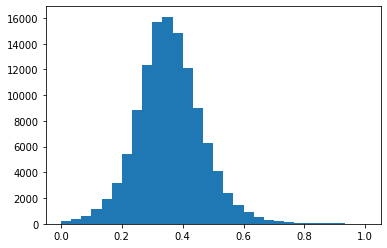

In [23]:
plt.hist(pred_y, bins=30); plt.show()

## Random Forest

50
100
150
200
50


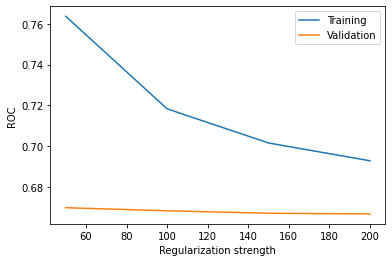

In [38]:
from sklearn.ensemble import RandomForestRegressor
n_estimators = 100
alpha = np.arange(10, 60, 10)
train_roc, val_roc = [], []
for m in alpha:
    print(m)
    clf = RandomForestRegressor(n_estimators=n_estimators, min_samples_leaf=m, criterion='squared_error', n_jobs=-1)
    clf.fit(train_x, train_y)
    
    val_roc.append(roc_auc_score(val_y, clf.predict(val_x)))
    train_roc.append(roc_auc_score(train_y, clf.predict(train_x)))

print(alpha[np.argmax(val_roc)])
train_val_plot(alpha, train_roc, val_roc, 'ROC', savefig=False, figname=None)

In [ ]:
clf = RandomForestRegressor(n_estimators=n_estimators, min_samples_leaf=1000, criterion='squared_error', n_jobs=-1)
clf.fit(final_train_x, final_train_y)

In [ ]:
pred_y = clf.predict(val_x)
roc_auc_score(val_y, pred_y)

In [ ]:
pred_y = clf.predict(test_x)
pred_to_csv(pred_y, test, 'results/randomforest_submission2.csv')

In [ ]:
plt.hist(pred_y, bins=30); plt.show()